# Multi-Channel Representation for Quantum Images - MCRQI

### <font color="brown">This image representation technique bases on FRQI. Image is encoded as follows:</font>

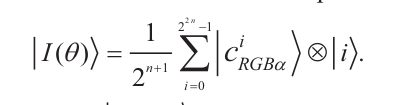

#### <font color="blue">Where : 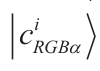 Color information which carrying the information R,G,B and α channel defined as:</font>


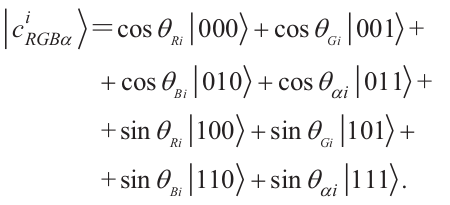

#### <font color="blue">where: 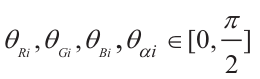   are the vectors encoding the colors of the R, G, B and α respectively and      ⨂  is the tensor product notation  </font>



## <font color="red">Step 1: image generating

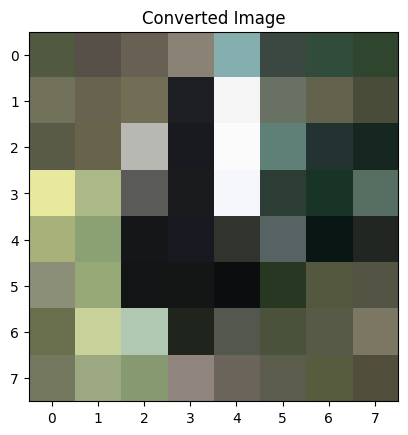

In [61]:
from qiskit import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import numpy as np
import math
from qiskit.circuit.library.standard_gates.ry import RYGate

# Load an image from file
image = cv2.imread('sample.jpeg')  
# Check if the image was loaded successfully
if image is None:
    print('Error: Could not open or find the image.')
else:
    # Resize the image to 8x8 pixels (you may need to adjust the size as needed)
    image = cv2.resize(image, (8, 8))

    # Convert the image to the desired format (8x8x3 matrix)
    image_matrix = np.zeros((8, 8, 3), dtype=np.uint8)
    image_matrix[:, :, 0] = image[:, :, 2]  # Red channel
    image_matrix[:, :, 1] = image[:, :, 1]  # Green channel
    image_matrix[:, :, 2] = image[:, :, 0]  # Blue channel

    # Display the converted image
    plt.imshow(image_matrix)
    plt.title('Converted Image')
    plt.show()

## <font color="red">Step 2: MCRQI Encoding

In [62]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc



# The Above code defines two functions:

   ## <font color="red"> 1. params(image) </font>
 
   ## <font color="red"> 2. rgb_circ(image)</font>
   

### params(image) function:

<font color="brown">
    <ul>
        <li> This function takes an input image as its parameter.</li>
        <li> It calculates the number of quantum bits (qubits) needed to represent the dimensions of the input   
             image in a quantum circuit. </li>
        <li> The number of qubits needed for the width is determined by xqbits, and the number of qubits needed   
             for the height is determined by yqbits.</li>
        <li> The function returns a tuple of integers (xqbits, yqbits) representing the number of qubits needed 
             for the width and height, respectively.</li>
    </ul>
</font>

### rgb_circ(image) function:

<font color="brown">
    <ul>
       <li> This function takes an input image and constructs a quantum circuit to process it.</li>
       <li> It calls the params(image) function to calculate the number of qubits needed for the image dimensions.</li>
       <li> It creates a QuantumRegister qr to hold the qubits needed for processing the image. The total number of qubits in this register is xqbit + yqbit + 3, where 3 stands for the RGB qubits.</li>
       <li> It also creates a ClassicalRegister cr to store the measurement results of the quantum circuit.</li>
       <li> The quantum circuit is initialized as qc.</li>
       <li> The function then performs various quantum operations on the circuit:
      <ul>
        <li>Swaps qubits in the first part of the register for some specific pattern.</li>
        <li>Applies Hadamard gates to the qubits in the register.
        <li>Iterates through the image pixel values, maps them to quantum rotations (RYGate),and applies                     controlled rotations based on the pixel values and qubit states.</li>
        <li>Swaps qubits again to undo the earlier swap operation.</li>
        <li>Finally, it applies a swap operation between the last and third-to-last qubits.</li>
      </ul>
        </li> 
     <li>After the quantum operations, the function adds measurement operations to measure all qubits.</li>
     <li>The constructed quantum circuit qc is returned.</li>
   </ul>    
</font>

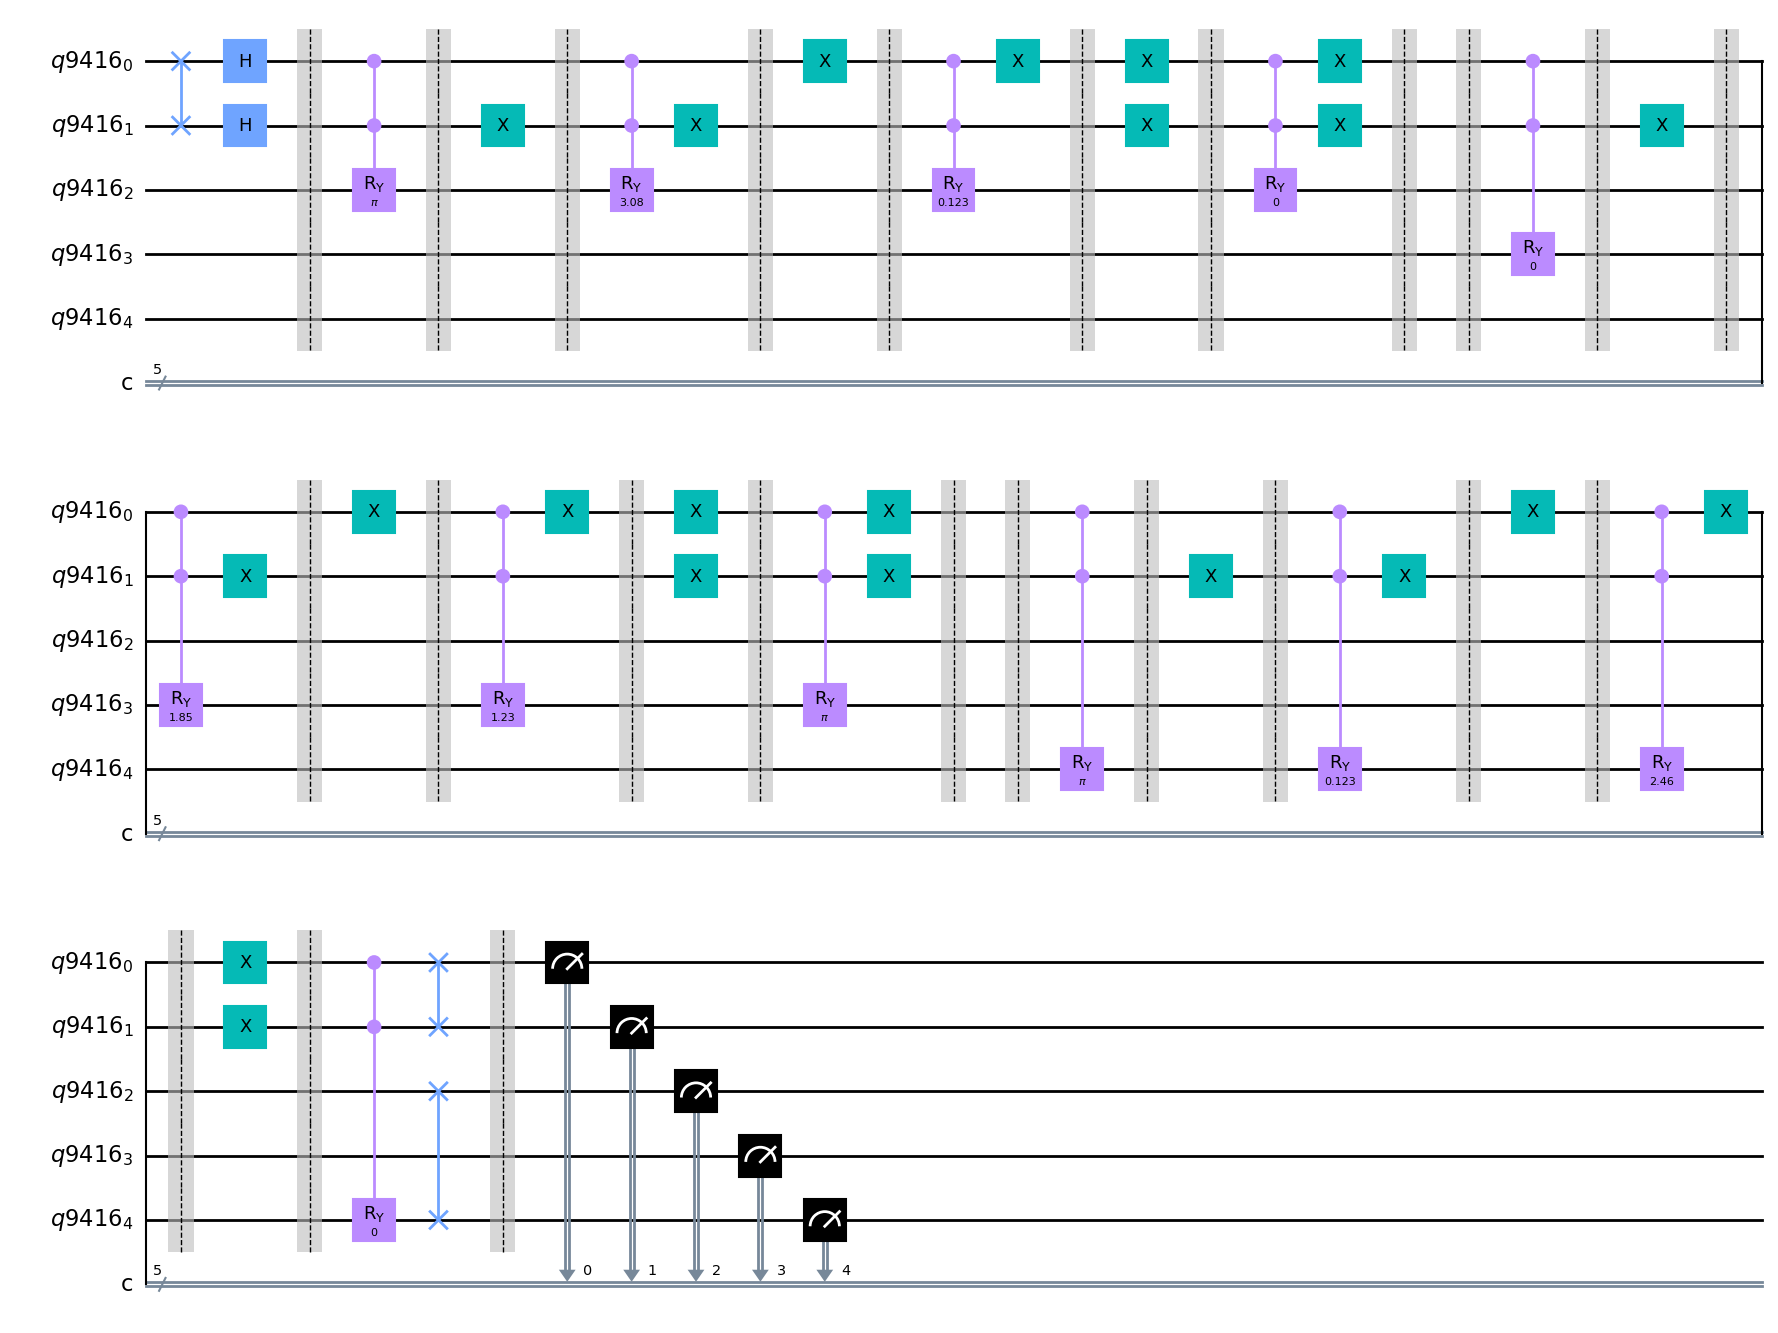

In [63]:
from qiskit.visualization import circuit_drawer

circuit_drawer(qc, output='mpl')

## <font color="red">Step 3: Circuit Execution

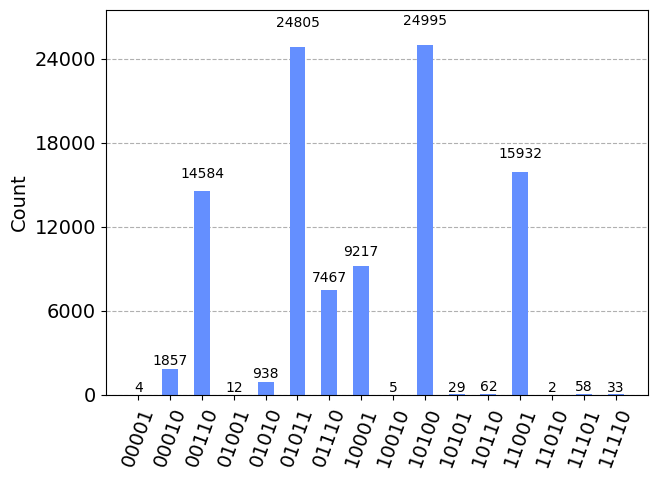

In [64]:
def run_qc(qc, shots=1000):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    return counts
plot_histogram(counts)

In [65]:
qc = rgb_circ(image)
counts = run_qc(qc)

/tmp/ipykernel_7330/3031209999.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = aer_sim.run(qobj).result()


## <font color="red"> Step 4: Measurments Interpretation

In [66]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T


### <font color="blue">The reconstruct_rgb function:

The reconstruct_rgb function takes measurement counts obtained from a quantum circuit and uses them to reconstruct an RGB image. The reconstruction process appears to involve some non-trivial calculations based on the counts of 0s and 1s for each pixel in each color channel. The reconstructed image is stored and returned as a NumPy array.


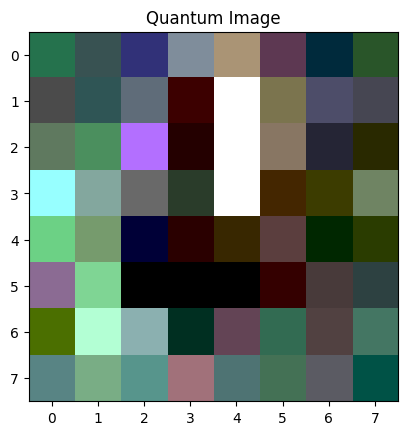

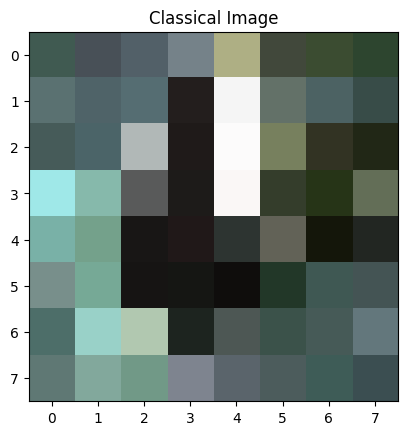

In [67]:
output_ims = reconstruct_rgb(image, counts, to_print = False)#reconstructs an RGB image from quantum measurement counts using the reconstruct_rgb function.
plt.imshow(output_ims)
plt.title('Quantum Image')
plt.show()
plt.title('Classical Image')
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


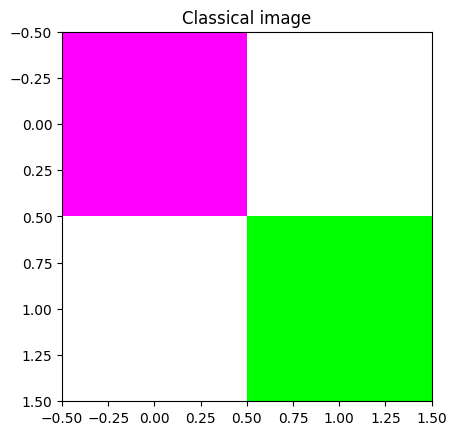

In [68]:
image = np.zeros((2,2,3))
image[:,:,0] = np.array(
           [255, 10,
            250,   0]).reshape(2,2)

image[:,:,1] = np.array(
           [0, 100,
            150, 255]).reshape(2,2)

image[:,:,2] = np.array(
           [255, 200,
            10,   0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical image')
plt.show()


#### The above code creates a simple 2x2 pixel classical image with specific pixel values in the Red, Green, and Blue channels. When displayed, it will show a small color image. The pixel values in each channel determine the colors in the image, where [255, 0, 255] represents magenta, [10, 100, 200] represents shades of gray, and [250, 150, 10] represents various shades of brown and orange.


/tmp/ipykernel_7330/3031209999.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = aer_sim.run(qobj).result()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


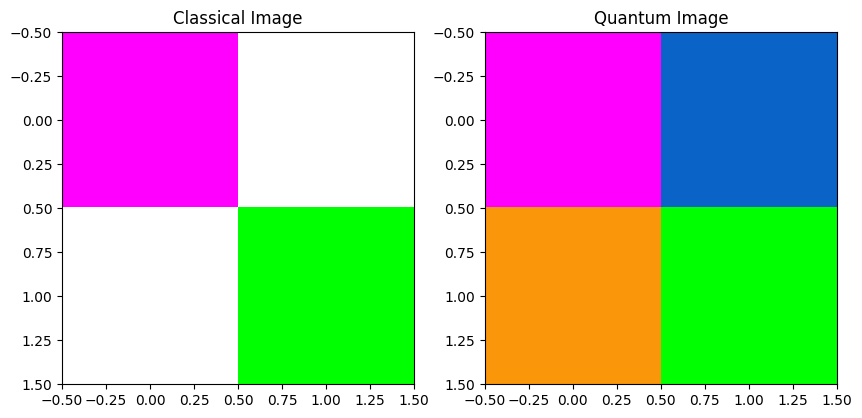

In [69]:
qc = rgb_circ(image)
counts = run_qc(qc, shots=100000)
output_ims = reconstruct_rgb(image, counts, to_print = False)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Classical Image')
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title('Quantum Image')
plt.imshow(output_ims)


#### The provided code appears to perform quantum image processing using a quantum circuit (qc) created from an input image, and then it compares the quantum-processed image with the original classical image using Matplotlib for visualization. 

### <font color="blue">Reference: 

 Sun, B., Iliyasu, A., Yan, F., Dong, F., & Hirota, K. (2013). An RGB multi-channel representation for images on quantum computers. J. Adv. Comput. Intell. Intell. Inform, 17(3).